In [1]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# **Tutorial on Building Fast Emulators in Climate Modeling**

Authors:

*   Björn Lütjens, MIT EAPS, lutjens@mit.edu
*   Lea M. Hadzic, Stanford University
*   Mark Veillette, MIT Lincoln Laboratory

Advisors:
*   Duncan Watson-Parris, UC San Diego
*   Dava Newman, MIT Media Lab
*   Raffaele Ferrari, MIT EAPS
*   Noelle Selin, MIT IDSS

Climate models are essential in policy making. Ideally, policy makers would like to interact with climate models through quick 'what-if' questions. For example, 'what-if we plant one trillion trees' or 'what if we support carbon tax'. However, current climate models need supercomputers and are overall too impractical to give quick answers. The below TEDx video goes into more detail. 

This tutorial will teach machine learning (ML) practitioners and Earth scientists about a possible solution: fast approximations of climate models. We call those approximations 'emulators'. For the ML community, we introduce the in-/output dimensions, how to access data, the strength of a linear baseline, and common evaluation protocols for getting started with climate emulation. For the Earth scientist, we highlight key learnings in picking the functional form that ML shall learn, the need for non-ML baselines, and the risk of overfitting to internal variability.

***How Machine Learning can Empower Local Climate Voices* | Björn Lütjens | TEDxBoston**

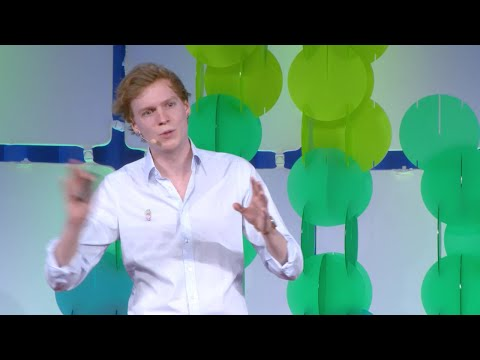

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('DTX8SvdtrmU')

## Table of Contents

*   [Introduction](#Introduction)
    *   [Climate Impact](#Climate-Impact:-Emulators-empower-local-climate-voices)
    *   [Target Audience, Background, and Prerequisites](#Target-Audience,-Background,-and-Prerequisites)
    *   [Installation](#Installation)
*   [Data](#Data)
    *   [Data Description](#Data-Description)
    *   [Data Download](#Data-Download)
    *   [Data Preprocessing](#data-processing)
    *   [Selecting the in- and output variables](#inputs-and-outputs)
    *   [Data Visualization](#Data-Visualization)
*   [Methodology](#methodology)
    *   [Piecewise Linear Emulator](#Piecewise-Linear-Emulator)
        * [Global CO2 to T](#linear-co2-to-tas)   
        * [Global T to local T](#global-to-local-tas)   
*   [Results & Discussion](#results-and-discussion)
    *   [Evaluating Climate Emulators](#Evaluating-Climate-Emulators)
    *   [CNN-LSTM: Comparison with a large deep learning model](#cnn-lstm)
    *   [Data vs. model complexity: Polynomial Pattern Scaling](#polynomial-pattern-scaling)
*   [Conclusion](#conclusion)
    *   [Summary](#Summary) 
    *   [Next Steps](#Next-Steps) 
*   [References](#references)


# Introduction

## Climate Impact: Emulators empower local climate voices

Rapid climate emulators are already used by policy and decision makers to learn about the impact of climate policies. For example, the [en-roads simulation](https://en-roads.climateinteractive.org/) below lets us rapidly explore the impact of reducing deforestation onto global temperature. However, it's unclear how global mean temperature relates to impacts at the state or city level. In this tutorial, we create an emulator that fills this gap. 

![SegmentLocal](docs/figures/tutorial/en-roads.gif "segment")a

To our ML scientist: This rapid exploration of climate policies is not possible with current global climate models due to their computational complexity. The crux of the computational complexity is that the underlying differential equations have to be solved for every scenario or parameter update from scratch. Machine learning (ML) promises a paradigm shift: the idea behind ML-based ‘*emulators*’ is to train ML models on large databases of simulated data. After training, the model will have memorized how to solve the differential equations and can be quickly run again for new parameter updates.

In the Earth Sciences, ML-based emulators have attracted a lot of attention by [predicting weather in seconds rather than hours](https://doi.org/10.1126/science.adi2336), but it is an open research question if the same will work on the much longer time scales of climate modeling. This tutorial will show that large-scale ML models are likely an overkill for emulating average temperatures and better used for more complex relationship.

<!-- and in machine learning due to challenges in physical structure, high-dimensionality, and long-term stability. While there exists tutorials for emulating the weather (Pathak et al., 2022), emulating the climate poses different challenges. Specifically, physical-consistency and long-term stability are fundamental in developing emulators that have to extrapolate multiple years beyond the data they have been trained on.-->

<!-- Modeling the possible outcomes of anthropogenic drivers of climate change, including its impacts on society and ecosystems, is important for decision makers to define adequate and effective adaptation and mitigation measures. Since a multitude of different emission pathways compatible with the Paris agreement exist, they critically rely on climate models to be able to understand climate change and climate policies. Most climate models, however, require supercomputers which are inaccessible to the general public. As a result, any task that requires multiple model runs, such as risk or sensitivity analyses, is expensive. In particular, interacting with climate models through educational ‘what-if’ scenarios, e.g. ‘what-if we plant one trillion trees,’ is too expensive (O’Neill et al., 2016). Consequently, policy makers have to mostly rely on simple approximations instead (Millar et al., 2017). They need better climate emulators to explore local climate impacts and enable more precise decisions.-->
<!--## Overview
This tutorial will implement an interactive climate emulator that can be used to explore ‘what-if’ climate policies. Our goal is to enable Earth scientists to develop emulators for their research and ML scientists to take on the challenges in climate data. Since every Earth science emulator will require different choices, our tutorial will focus on explaining those choices, i.e. when to use non-ML vs. ML and how to incorporate physical knowledge. The final model can be used to illustrate and explore climate policies. Building on En-ROADS, this will be the first interactive and spatially-resolved climate policy emulator.-->


## Target Audience, Background, and Prerequisites

This tutorial is primarily intended for data scientists that are interested in climate modeling. Specifically, we will introduce a novel time-series, video, and real-world dataset that introduces challenges in long-term stability, multiscale spatiotemporal modeling, and physical consistencies. We will also point out learning to Earth scientist. The users of this tutorial are expected to have familiarity with Python, pytorch, general deep learning models, and the deep learning pipeline (dataloader, optmizer, loss fn, etc.). A background in climate science is not necessary. The users will walk away with a notebook on how to access and fit a baseline emulator model on a common climate dataset.

Prerequisite references:
- Book on deep learning basics: [I. Goodfellow, Y. Bengio, A. Courville, Deep Learning, book](https://github.com/janishar/mit-deep-learning-book-pdf)
- (optional:) Primer on climate models: [Carbon Brief](https://www.carbonbrief.org/qa-how-do-climate-models-work/)

Related material to this tutorial: 
- A tutorial on downscaling weather and climate data: [ClimateLearn](https://colab.research.google.com/drive/1dQ_V5-y1ieRqrpTG4po_Kx_D8NvZwRyK?usp=sharing#scrollTo=k7JdGELMXpIw)

## Installation

The required software is managed at [github.com/blutjens/climate-emulator-tutorial](https://github.com/blutjens/climate-emulator-tutorial). Running the cell below will install the required dependencies. This notebook can be run in a local jupyter notebook or Google colab. The following domain specific packages are installed as part of this call:

*   `torch`- Deep learning library
*   `xarray`- Wrapper around numpy to have labeled arrays. Standard for climate data.
*   `netcdf`- Data storage format of most climate data
*   `cartopy` - Geospatial plotting
*   `emcli` - Codebase on climate emulators developed for this tutorial

In [3]:
%%capture
import os
repo_root = './' # use 'climate-emulator-tutorial/' on colab and './' on local machine

if not os.path.exists(repo_root):
    !git clone https://github.com/blutjens/climate-emulator-tutorial # clone the git repo
    !pip install -r climate-emulator-tutorial/requirements.txt   # install all requirements
    !pip install -e climate-emulator-tutorial/                   # install this tutorial package, called emcli

In [4]:
# Import all modules

# Data visualization
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# optional: code to mount GPU onto colab can be inserted here. 

# Data

## Data Description

There exist much climate data. Indeed the CMIP6 dataset contains over 20 petabyte (PB) of data from over 50 climate models. The CMIP6 dataset is the primary source for synthesizing climate information to policy and decisionmakers as part of the [IPCC AR6 Report](https://www.ipcc.ch/). Each climate model uses as input a prescribed trajectory of co2, methane, and aerosol emissions, which are called shared socioeconomic pathways (SSPs). Given one scenario, the climate model then solves many differential equations of the atmosphere, ocean, land, and ice on a supercomputer to predict the climate from 1850 to 2100 and outputs a 3D grid of state variables, such as temperature, wind, pressure, and humidity, at typically 30min temporal and 1° spatial resolution with an additional vertical grid. The CMIP6 data contains spatiotemporal averages and downstream variables of those variables. 

## Data Download

The full set of CMIP6 data can be downloaded at [ESGF](https://esgf-node.llnl.gov/projects/esgf-llnl/), which can take some effort. Thus, we leverage the [ClimateBenchv1.0 dataset](https://doi.org/10.1029/2021MS002954), which is a benchmark dataset for emulation of climate variables derived from a full complexity Earth System Model, and slightly modify it (Watson-Parris et al., 2022). The ClimateBench data was assembled to study the impact of greenhouse gases (GHGs) and aerosols onto temperature and precipitation. All data in ClimateBench comes from only a single model (NorESM2) within the CMIP6 dataset.

In [5]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# drive.flush_and_unmount()

In [6]:
data_root = repo_root + 'data/'
path_climatebench_data = data_root + 'raw/climatebench/' # climatebench data

In [7]:
# Download ClimateBench into Google drive. Downloading the 914MB can take ~25min.
if not os.path.exists(path_climatebench_data):
    os.makedirs(path_climatebench_data)
if not os.path.exists(path_climatebench_data + 'train_val.tar.gz'):
    ! wget https://zenodo.org/record/7064308/files/train_val.tar.gz -P $path_climatebench_data
    ! tar -xvf "$path_climatebench_data/train_val.tar.gz" -C $path_climatebench_data
if not os.path.exists(path_climatebench_data + 'test.tar.gz'):
    ! wget https://zenodo.org/record/7064308/files/test.tar.gz -P $path_climatebench_data
    ! tar -xvf "$path_climatebench_data/test.tar.gz" -C $path_climatebench_data

## Data Preprocessing <a name="data-processing"></a>

This section formats the raw data into a CO2 -> temp mapping.

The raw ClimateBench data contains annual snapshots of temperature, precipitation, extreme precipitation, diurnal temperature and four greenhouse gases (co2, ch4, bc, and so2) from five climate scenario simulations. Each snapshot is a (144 x 96) pixel image (width x length; lon x lat). Three scenarios have only been run on the past (hist-GHG, hist-aer, and historical) containing data from 1850-2014 and four scenarios (ssp126, -245, -370, and -585) have only been run on the future, but stacked with historical data to contain all years from 1850–2100. The data in each scenario is averaged across three realizations; each realization in the ground-truth climate model uses the same forcings, but slightly different initial conditions. The scenarios are detailed in [ClimateBench Table 1](https://doi.org/10.1029/2021MS002954). We hold out one scenario from the 'middle range' (ssp245) and train on the other five to evaluate if a learned model can interpolate.

In [8]:
#@title code: load ClimateBench training data
from emcli.dataset.climatebench import load_climatebench_data

scenarios_train = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer']
len_historical = 165
data_path = path_climatebench_data + '/'

X_train, Y_train = load_climatebench_data(
  simus=scenarios_train, len_historical=len_historical, 
  data_path=data_path)

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


In [9]:
#@title code: Load test data

scenarios_test = ['ssp245']

X_test, Y_test = load_climatebench_data(
  simus=scenarios_test, 
  len_historical=len_historical, 
  data_path=data_path,
  avg_over_ensemble=True)

# opt: Drop non-relevant variables
# X_test = [X.drop(['SO2','CH4','BC']) for X in X_test]
# Y_test = [Y.drop(['diurnal_temperature_range','pr','pr90']) for Y in Y_test]

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp245


In [10]:
print('Input', X_train[0].data_vars)
print('Output', Y_train[0].data_vars)
print('Training set, number of scenarios:\n\t', len(X_train))
print('Training set, shape of CO2 input and tas output for historical scenario:\n\t', X_train[3]['CO2'].shape, Y_train[3]['tas'].shape)
print('Test set, number of scenarios:\n\t', len(X_test))
print('Test set, shape of CO2 input and tas output:\n\t', X_test[0]['CO2'].shape, Y_test[0]['tas'].shape)

Input Data variables:
    CO2      (time) float64 0.1883 0.3772 0.5738 ... 2.798e+03 2.793e+03
    SO2      (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 3.525e-14
    CH4      (time) float64 0.03131 0.03174 0.03218 ... 0.115 0.1143 0.1136
    BC       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 4.3e-15
Output Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 0.03264 .....
    tas                        (time, latitude, longitude) float32 0.32 ... 3...
    pr                         (time, latitude, longitude) float64 0.02337 .....
    pr90                       (time, latitude, longitude) float64 0.02468 .....
Training set, number of scenarios:
	 5
Training set, shape of CO2 input and tas output for historical scenario:
	 (165,) (165, 96, 144)
Test set, number of scenarios:
	 1
Test set, shape of CO2 input and tas output:
	 (251,) (251, 96, 144)


## Selecting the in- and output variables <a id="inputs-and-outputs"></a>

Our goal is to emulate climate models, but presented with 20PB of data, we have to make a choice on which exact relation will to emulate. Here, we decided to map CO2 emissions onto local temperatures. To explain this decision, let us first plot the annual and global average of all data variables in the dataset:

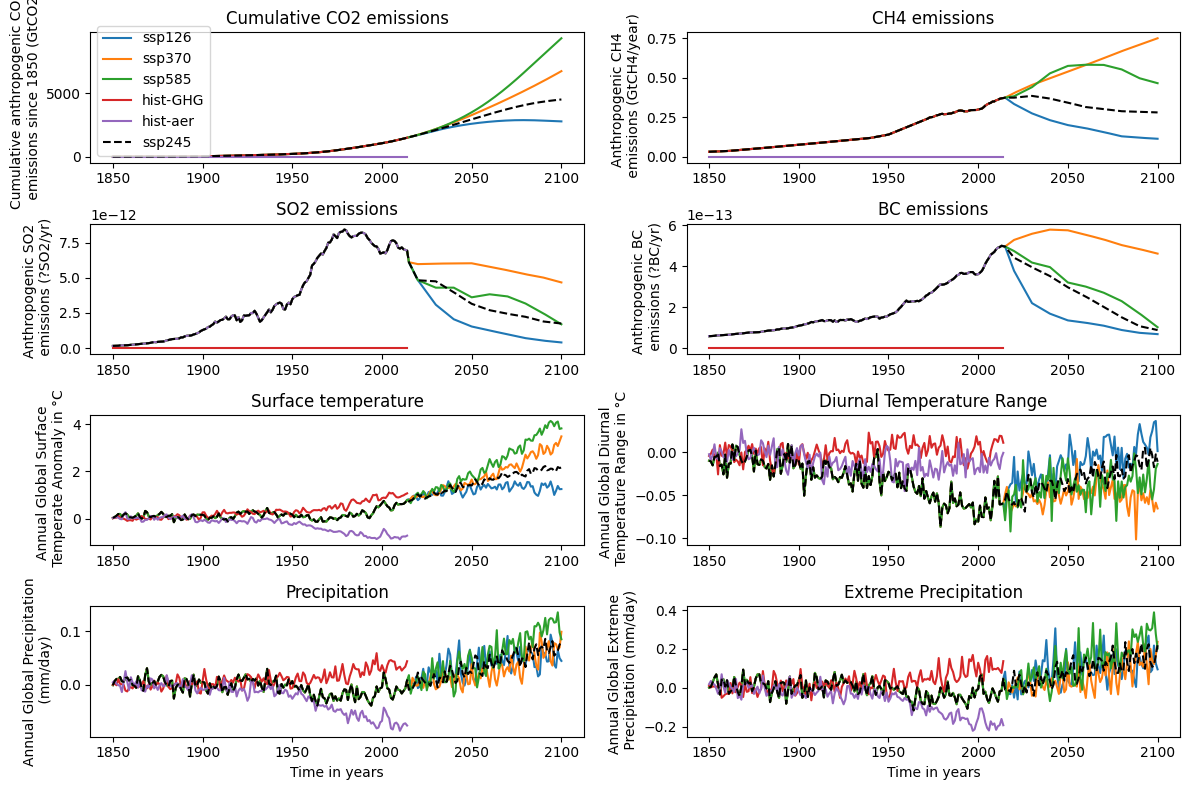

In [11]:
import emcli.utils.plotting as plotting

axs = plotting.plot_all_vars_global_avg(X_train=X_train, 
            X_test=X_test, 
            Y_train=Y_train, 
            Y_test=Y_test,
            scenarios_train=scenarios_train,
            scenarios_test=scenarios_test)

As we can see, the ClimateBench dataset contains various greenhouse gases and aerosols that we could use as inputs: cumulative carbon dioxide (co2), methane (ch4), sulfur dioxide (so2), and black carbon (bc). We decide to use the annually- and globally-averaged cumulative co2 emissions as inputs, because they are the strongest signal in the relationship to surface temperatures (see ClimateBench, Appendix). CO2 is well-mixed on the annual timescale, so we will use a global average as input; using locally-resolved data would like not provide much benefit. Using only co2 as input, we'll need to be aware that the variation in the other variables (ch4, so2, and bc) will be confounding our predictions.

As learning targets, the dataset contains the following impact variables: surface temperature anomalies, diurnal temperature range, precipitation, and extreme precipitation. We decided to use annually-averaged maps of surface temperature anomalies (i.e., the change in temperature since 1850), abbreviated (tas). We choose temperature as introductory variable and point to precipitation, humidity, pressure, winds, etc. as variables for future emulators.

## Data Visualization

Now, let us plot our learning target and inputs. First, we plot the target surface temperature average from 2080-2100 in the validation set. We can see that there's stronger warming in the Northern than in the Southern Hemisphere. The warming is higher over land than over the Ocean. The Arctic warms particularly fast, which is called Arctic amplification. And the climate model predicts a cooling below Greendland, which is called the North Atlantic warming hole.

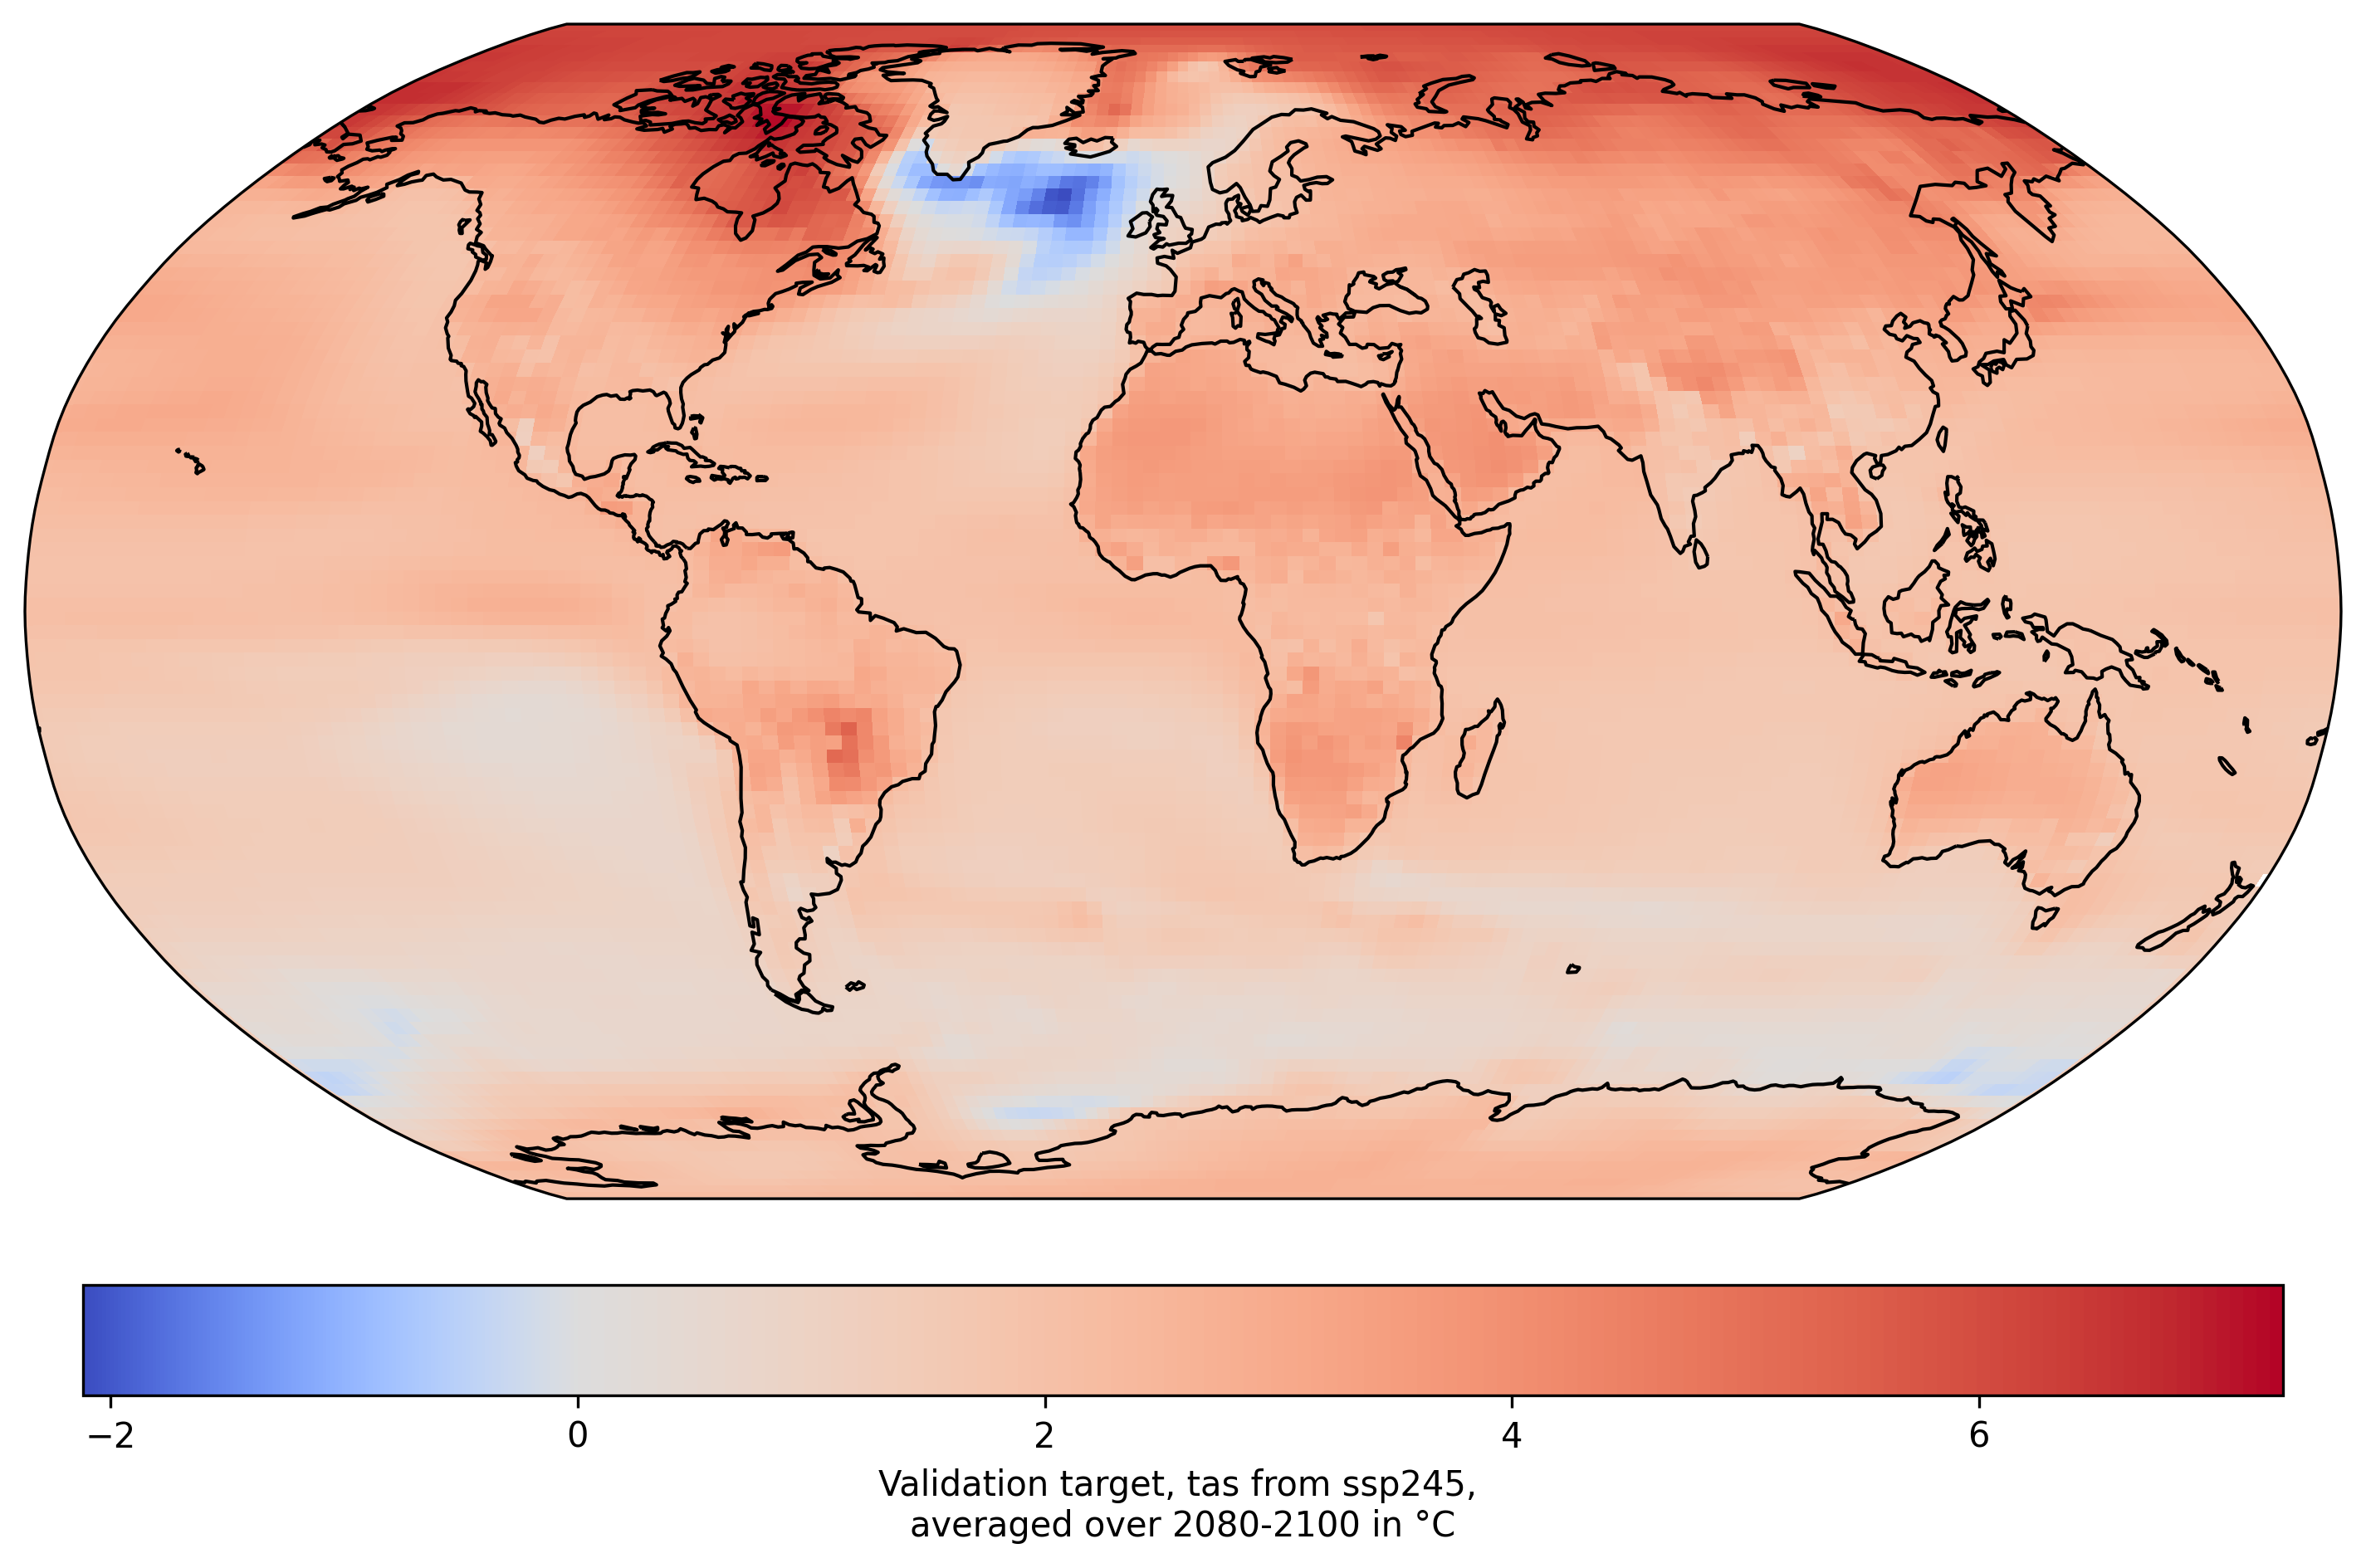

In [19]:
# Select ssp245 and surface temperatures from validation dataset
data_var = 'tas'
tas_true = Y_test[0][data_var]

# Compute temporal average of target and prediction to average out
#  internal variability over evaluation timeframe
tas_true_t_avg = tas_true.sel(time=slice("2081", "2100")).mean(dim="time")

# Create figure with PlateCarree projection
projection = ccrs.Robinson(central_longitude=0)
transform = ccrs.PlateCarree(central_longitude=0)
fig, axs = plt.subplots(1, 1, figsize=(12, 9), 
    subplot_kw=dict(projection=projection),
    dpi=300)

# Plot ground-truth surface temperature anomalies
cnorm = colors.TwoSlopeNorm(vmin=tas_true_t_avg.min(), vcenter=0, vmax=tas_true_t_avg.max()) # center colorbar around zero
mesh = axs.pcolormesh(tas_true.longitude.data, tas_true.latitude.data, 
                         tas_true_t_avg.data, cmap='coolwarm',
                         norm=cnorm, transform=transform)
cbar = plt.colorbar(mesh, ax=axs, orientation='horizontal', shrink=0.95, pad=0.05)
cbar.set_label(f'Validation target, {data_var} from ssp245, \naveraged over 2080-2100 in °C')
cbar.ax.set_xscale('linear')
axs.coastlines()


Next, we plot the input variable: globally- and annually-averaged cumulative co2 emissions. 

An important learning is that climate data contains a lot of internal variability. We can see the internal variability in plotting globally- and annually-averaged surface temperature (middle plot). The temperature has a strong year to year variation that is not visible in the smooth co2 input signal. This, is because the internal variability comes from others factors, such as climate and weather modes like the El Nino Southern Oscillation or Madden-Julian Oscillation. The onset year of such climate modes is currently unpredictable, even by the best models. So, in our design of the climate emulator, we will need to average over this signal. It is common practice to reduce the internal variability by averaging over all realizations, but our dataset only has three realizations per scenario. So, instead we average over realizations and take a 20-year average in the validation dataset.

What's more, we can see that the temperature increase is almost a linear function of the cumulative co2 emissions, by creating a scatter plot (right). This relationship seems to brake primarily only for hist-aer, a scenario of historical emissions with withheld co2 emissions.

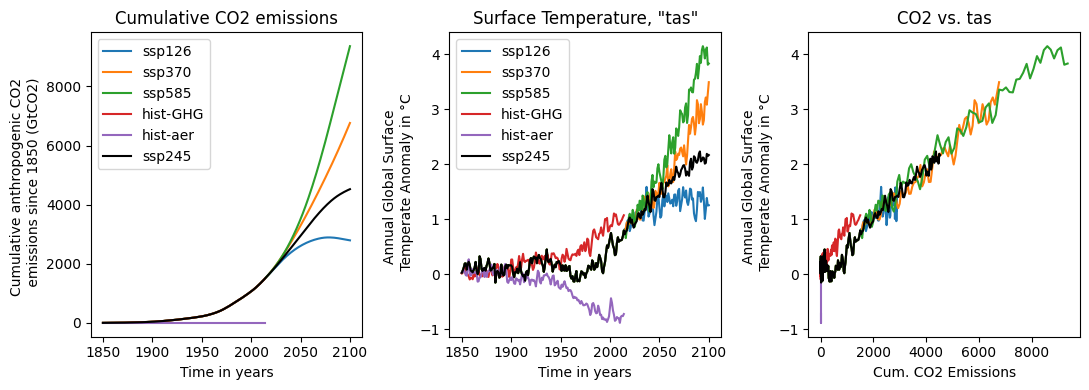

In [20]:
%reload_ext autoreload
%aimport emcli

import emcli.utils.plotting as plotting
from emcli.dataset.climatebench import DATA_VAR_LABELS 
data_var = 'tas'
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          data_var=data_var,
          data_var_labels=DATA_VAR_LABELS);

Most ML models require in-/ and outputs that are normalized to zero-mean and unit variance. We will only fit simple models that don't require normalization.

In [16]:
# Calculate basic statistics 
from emcli.dataset.climatebench import compute_mean_std_X_train
# optionally normalize: from emcli.dataset.climatebench import normalize_data_arr

# Compute mean and standard deviations of each input variable
meanstd_inputs = {}
for var in ['CO2']:
    meanstd_inputs[var] = compute_mean_std_X_train(data_arr = X_train, var=var)

print('Mean and standard deviations:')
[print('\t' + key + ' train mean, std: \t', meanstd_inputs[key]) for key in meanstd_inputs];

Mean and standard deviations:
	CO2 train mean, std: 	 (1074.172303244536, 1755.690699230666)


<a name="methodology"></a>
# Methodology: Mapping GHGs(t) -> temperature(t)

Choosing the model is a function of data availability, data complexity, and domain knowledge that should be incorporated.

**Model complexity:** First, we would like to match the model complexity to the data availability and complexity. We can roughly order the common ML models by complexity: linear model < random forest < Gaussian Process < CNN, Neural Operator, GNN < LSTM < CNN-LSTM < Transformer.

**Spatial inductive bias:** Further, we can incorporate domain knowledge in the deep learning architecture by choosing a model with spatial inductive biases. For example, CNNs are good for learning local relationships, neural operators for learning spectrally smooth data, graph neural networks for learning teleconnections, random forests for feature-driven data, and Gaussian Processes for spatially smooth probabilistic data, etc. Transformers are designed to have minimal inductive biases. Diffusion and GAN models are characterized primarily through their loss function and often use CNNs.

**Incorporating time:** 
RNNs or LSTMs are the go-to choice in deep learning for capturing temporal relationships. The popularity of deep learning, however, brushes over powerful traditional models, such as linear ODEs and ARIMA. 

**Linear baseline:** ClimateBench already implemented a random forest, Gaussian Process, and CNN-LSTM. Especially, the CNN-LSTM, however, is a very complex model with millions to billions of parameters. We hypothesized that there is not sufficient data available to match the CNN-LSTM's model complexity. So, we decided to test a linear model. We incorporate spaitla domain knowledge by assuming local independence, i.e., the temperature at every grid point is independent of the temperature at other grid points, given the global average temperature. Lastly, we incorporate time simply by using the cumulative emissions instead of emissions as input and predict the temperatures at the same year. 

## Piecewise Linear Emulator

Our final model will be two linear models. The first model maps the globally-average co2 onto the globally-averaged surface temperature increase: 

- $f_{global}: co2_{global-avg}(t) \in \mathbb{R} \rightarrow tas_{global-avg}(t) \in \mathbb{R}$

The second model is called linear pattern scaling: We fit one linear regression model per grid cell. Each linear regression model fit uses all co2->tas data points across scenarios and time in the training dataset. After training, the model predicts the relationship in a held-out scenario. 

- $f_{local}: tas_{global-mean}(t) \in \mathbb{R} \rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$

In summary, we take the following assumptions:
  - Global temperature increase is a linear function of global cumulative co2 emissions.
  - Local temperature anomalies are spatially independent, given the global temperature anomaly.  
  - There is no memory. An instant quadrupling of CO2 will result in instant temperature quadrupling.
  - The variation of other features, e.g., ch4, so2, bc, is captured in co2

#### Linear time-instant: global CO2 -> global tas<a name="linear-co2-to-tas"></a>

In [14]:
#@title: fit linear model for global GHGs -> global tas

import emcli.models.pattern_scaling.model as ps
import emcli.dataset.interim_to_processed as i2p

# Convert training data from interim to processed
data_var = 'tas' # 'tas', 'pr'
dir_global_global = data_root + 'interim/global_global/'
input_train, target_train = i2p.interim_to_global_global(
                             X_global_local=X_train,#[:-1], # could leave out hist-aer for training, but didn't really matter
                             Y_global_local=Y_train,# [:-1],
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'train/')

print(target_train.shape)
# Fit Linear regression model from global ghg at t -> global data_var as t
model_lr = ps.fit_linear_regression_global_global(data_dir=dir_global_global+'train/', plot=False)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_co2_to_global_{data_var}.pkl'
ps.save(model_lr, dir=dir_pattern_scaling, filename=model_name)

# Convert test data from interim to processed
input_test, target_test = i2p.interim_to_global_global(X_global_local=X_test, # [X_train[2]],# 
                             Y_global_local=Y_test, # [Y_train[2]],#
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'test/')

# Load model
# model_lr = ps.load(dir=dir_pattern_scaling, filename=model_name)

# Apply linear regression model on test data
preds_lr = ps.predict_linear_regression_global_global(model_lr, 
            data_dir=dir_global_global+'test/',
            plot=False)

Saving processed data at:  ./data/interim/global_global/train/
(1083, 1, 1, 1)
Saving processed data at:  ./data/interim/global_global/test/


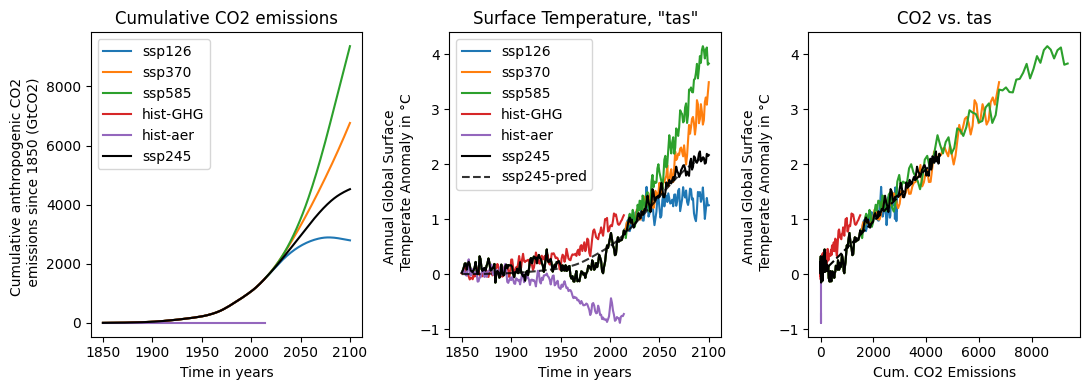

In [15]:
# Plot linear regression predictions

import emcli.utils.plotting as plotting
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          preds=preds_lr,
          data_var=data_var,
          data_var_labels=DATA_VAR_LABELS);

#### Linear pattern scaling: global tas -> local tas<a name="global-to-local-tas"></a>

In [16]:
#@title: fit linear pattern scaling model for global tas -> local tas

import emcli
import importlib
importlib.reload(emcli)
#from emcli.models.pattern_scaling.model import PatternScaling
#from emcli.models.pattern_scaling.model import save
import emcli.models.pattern_scaling.model as ps

data_var = 'tas' # 'tas', 'pr', 'pr90'
# Retrieve global temperatures for training
var_global = target_train.flatten() # (n_time,)
# Retrieve annual local temperature field for training
var_local = np.concatenate([dataset[data_var].data for dataset in Y_train],axis=0) # (n_time, n_lat, n_lon)

# Initialize and fit pattern scaling model
pattern_scaling = ps.PatternScaling(deg=1)
pattern_scaling.train(var_global, var_local)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_tas_to_local_{data_var}.pkl'
ps.save(pattern_scaling, dir=dir_pattern_scaling,filename=model_name)

# Retrieve test data. Use global tas predictions from previous model as input
var_global_test = preds_lr.flatten() # (n_time,)
# var_global_test = target_test.flatten() # (n_time,) # uncomment to use ground-truth global tas as input

# Load model
# pattern_scaling = ps.load(dir=dir_pattern_scaling)

# Apply pattern scaling model on test data
preds_pattern_scaling = pattern_scaling.predict(var_global_test) # (n_time, n_lat, n_lon)

<a name="results-and-discussion"></a>
# Results & Discussion

## Evaluating Climate Emulators

Evaluating the results of climate emulators is not trivial and not an entirely answered question. Here, we will only use error maps and average NRMSE to analyze our resutls, following ClimateBench.

Below, we can see the ground-truth surface temperature anomalies in the held-out scenario (ssp245), averaged over 2080-2100 (left). The time-averaged linear model prediction is displayed in the middle. The plot on the right shows the error: prediction - target. 

We can see that the linear model is surprisingly good. It accurately predicts the global warming patterns of a hotter Arctic, hotter land, North Atlantic warming hole. Creating the error plot reveals that the linear model overpredicts warming in the North Atlantic, Russian Arctic, and the Weddel Sea in the Southern Ocean next to the Larsen ice shelf. The linear model underpredicts warming in the Greenland sea.

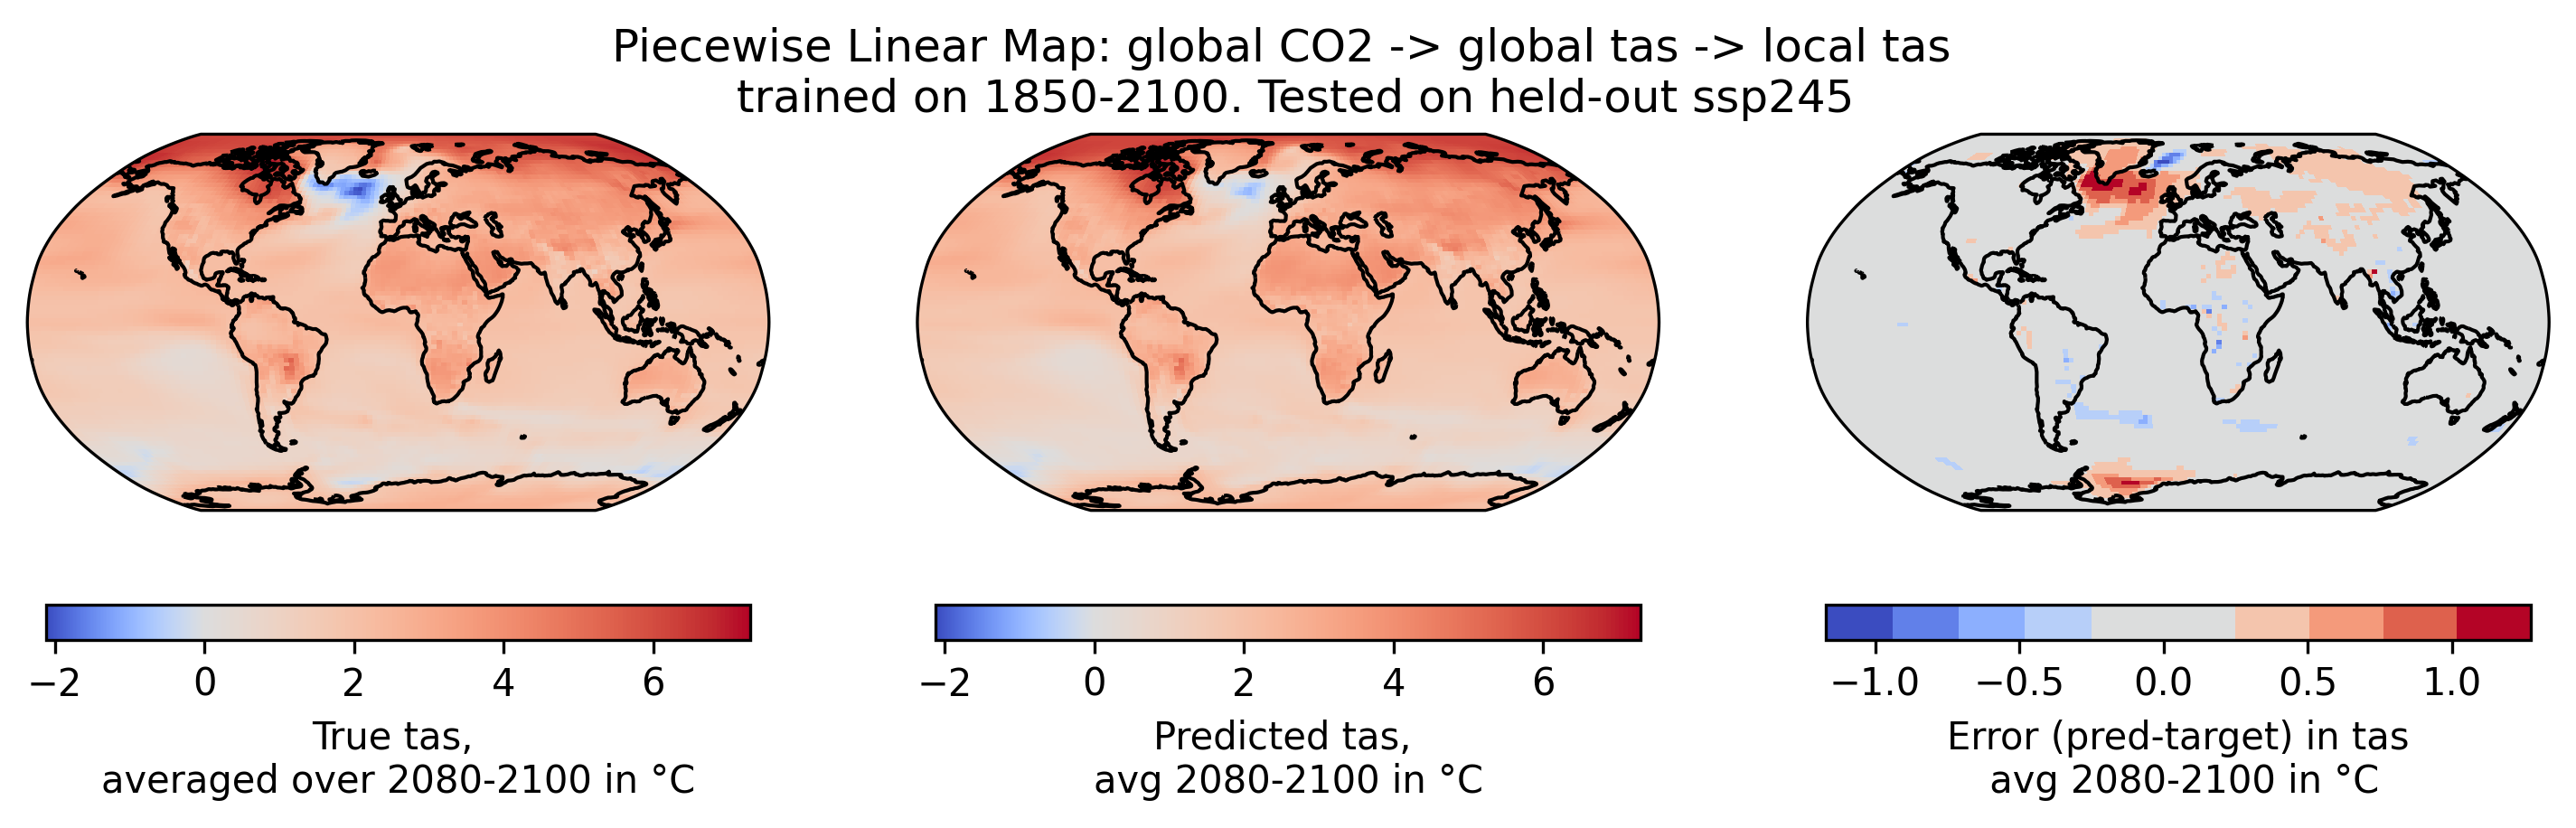

In [17]:
# Plot error map
from emcli.utils.plotting import plot_tas_annual_local_err_map

preds_pattern_scaling_xr = xr.DataArray(data=preds_pattern_scaling, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_ds = [xr.merge([preds_pattern_scaling_xr])]
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], preds_pattern_scaling_ds[0][data_var], data_var=data_var)
axs[1].set_title(f'Piecewise Linear Map: global CO2 -> global tas -> local {data_var} \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

To compare across models, we calculate the normalized root mean square error (NRMSE). To evaluate spatial accuracy, the NRMSE first calculates the MSE per grid cell and then calculates the global average instead of vice versa.

In [18]:
#from xskillscore import rmse
from emcli.utils.metrics import calculate_nrmse

Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_ds[0][data_var])
print(Y_nrmse)

0.07969081519021995


### CNN-LSTM: Comparison with a large deep learning model<a name="cnn-lstm"></a>

We know compare the linear pattern scaling model with the CNN-LSTM model in ClimateBench. The CNN-LSTM was trained and tested on the same dataset and data split -- holding out ssp245. However, CNN-LSTM uses globally-averaged methane (ch4), local maps of sulfur dioxide (so2), and local maps of black carbon (bc) as additional inputs. Further, the CNN-LSTM is trained and tested on time-snippets of length 10. The comparison between CNN-LSTM and our linear pattern scaling model is still fair, because the data in the linear pattern scaling is a strict subset of the CNN-LSTM data. In summary, the linear pattern scaling and CNN-LSTM models were trained on the following mapping:

- $f_{linear}: co2_{global-avg}(t) \in \mathbb{R} \rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$
- $f_{cnn-lstm}: [co2_{global-avg}(t{-}10{:}t), ch4_{global-avg}(t{-}10{:}t), so2_{0:lat, 0:lon}(t{-}10{:}t), bc_{0:lat, 0:lon}(t{-}10{:}t)] \in \mathbb{R}^{10} \times \mathbb{R}^{10} \times \mathbb{R}^{(lat,lon,10)} \times \mathbb{R}^{(lat,lon,10)} $
    $\rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$

Further details on the CNN-LSTM model are described in the ClimateBench paper.

Now, we compare the accuracy of CNN-LSTM vs. Linear Pattern Scaling. First, we plot the error maps (sourced from Fig. 4 and Fig. A2 in the ClimateBench). We can see that the CNN-LSTM has comparitively little error in the North Atlantic Warming Hole, Weddel Sea, and Greenland Sea. Therefore, the CNN-LSTM has a substantial bias to over (under-) predict warming in the Northern (Southern) hemisphere, respectively. From the error plots, it seems like the Linear Pattern Scaling model and CNN-LSTM model have complementary errors.

Surprisingly the NRMSE of the CNN-LSTM is 0.107, which is higher than the Linear Pattern Scaling NRMSE of 0.080. This indicates our hypothesis that there was not sufficient data available for the model complexity of the CNN-LSTM was likely true.

![ClimateBench CNN-LSTM](docs/figures/tutorial/tas_ssp245_2080_2100/climatebench.png)

## Data vs. model complexity: Polynomial Pattern Scaling<a name="polynomial-pattern-scaling"></a>
The fact that a linear model outperforms a large deep learning model brings us to the question if more complex models are necessary at all or if a linear model is just fine, for this task? Here, we saw that a linear model achieves most of the accuracy. Nevertheless, we learned that the data is not entirely linear, e.g., in the Arctic. To find the best model complexity, we're demonstrating a new plot: Performance vs. model complexity. If the best performing model is one with low complexity we know that our task is likely not very complex or inherently data limited. 

To plot performance vs. model complexity we slightly modify the Linear Pattern Scaling model from above. Instead of fitting a linear curve to every grid cell, we are now fitting a polynomial of degree n to each grid cell. Every grid cell has the same polynomial degree, but coefficients that are independent of the other grid cells. The model complexity is determinded by the polynomial degree.

In [39]:
## Find best polynomial degree in nonlinear pattern scaling that fits the data
# Initialize and fit pattern scaling model

from tqdm.notebook import tqdm 

degrees = np.arange(1,23)
Y_nrmse_over_degree = []
for degree in tqdm(degrees):
    pattern_scaling_poly = ps.PatternScaling(deg=degree)
    pattern_scaling_poly.train(tas_global, tas_local)

    # Apply pattern scaling model on test data
    preds_pattern_scaling_poly = pattern_scaling_poly.predict(tas_global_test) # (n_time, n_lat, n_lon)

    # Convert into xarray
    preds_pattern_scaling_poly_xr = xr.DataArray(data=preds_pattern_scaling_poly, 
        coords=Y_test[0]['tas'].coords, name='tas') # convert predictions into axarray
    preds_pattern_scaling_poly_ds = [xr.merge([preds_pattern_scaling_poly_xr])]
    """
    # Plot error map
    axs = plot_tas_annual_local_err_map(Y_test[0]['tas'], preds_pattern_scaling_poly_ds[0]['tas'])
    axs[1].set_title(f'Polynomial Pattern Scaling: global CO2 (linear: ->) global T (polynomial(deg={degree}): ->) local T \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
    plt.show()
    """
    # Calculate NRMSE
    Y_nrmse = calculate_nrmse(Y_true=Y_test[0]['tas'], Y_pred=preds_pattern_scaling_poly_ds[0]['tas'])
    Y_nrmse_over_degree.append([degree, Y_nrmse])

Y_nrmse_over_degree = np.transpose(np.array(Y_nrmse_over_degree))

  0%|          | 0/22 [00:00<?, ?it/s]

/mnt/c/Users/Bjoern/code/climate-emulator-tutorial/emcli/models/pattern_scaling/model.py:46: RankWarning: Polyfit may be poorly conditioned
  self.coeffs = np.polyfit(in_global, out_local, deg=self.deg) # (2, n_lat*n_lon)


Text(0.5, 1.0, 'NRMSE over Degree of Polynomial Pattern Scaling:\nLinear: global CO2 -> global T \n Polynomial: global T -> local T \n Trained on 1850-2100.\nTested on 2080-2100 in held-out ssp245')

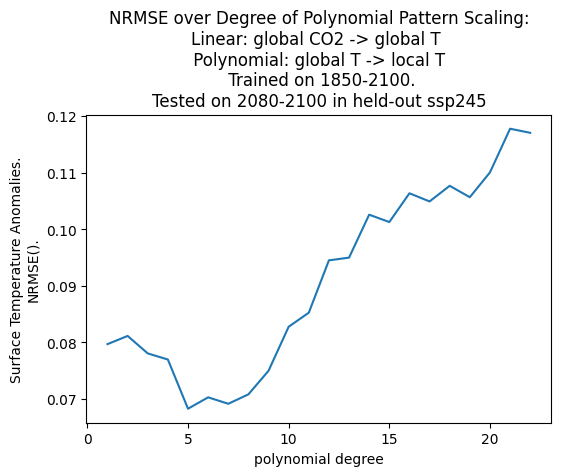

In [40]:
# Plot NRMSE over polynomial degree
fig, axs = plt.subplots(1,1, figsize =(6,4))
axs.plot(Y_nrmse_over_degree[0,:], Y_nrmse_over_degree[1,:])
axs.set_xlabel('polynomial degree')
axs.set_ylabel('Surface Temperature Anomalies.\nNRMSE().')
axs.set_title('NRMSE over polynomial degree. held-out ssp370.')
axs.set_title(f'NRMSE over Degree of Polynomial Pattern Scaling:\nLinear: global CO2 -> global T \n Polynomial: global T -> local T \n Trained on 1850-2100.\nTested on 2080-2100 in held-out {scenarios_test[0]}')

#### Polynomial pattern scaling: global tas -> local tas

The above plot shows that increasing model complexity can indeed improve the performance of our model. So, we pick the 5th order polynomial and show the error plot below. The NRMSE is 0.068 which is better than the linear model.

This plots indicates the a linear model (polynomial of 1st degree) is likely underfitting and a polynomial of higher order than 5 is likely overfitting the data. It is possible that the model could be further improved by increasing the data with more scenarios, taking more assumptions about the data, e.g., by fitting a different polynomial degree to the North Atlantic warming hole than the other grid cells, or using a very small fully-connected neural network per grid cell instead of a polynomial.

Overall, however, the accuracy we get with the polynomial fit seems very close to the best possible model in this evaluation. Particularly, the internal variability within the NorEMS2 data is very high with only three realizations. Increasing the model complexity will likely overfit on the internal variability. To better evaluate which errors originate in the model vs. internal variability, we would recommend to plot a map of internal variability, e.g., variance across realizations or years, next to the error map.

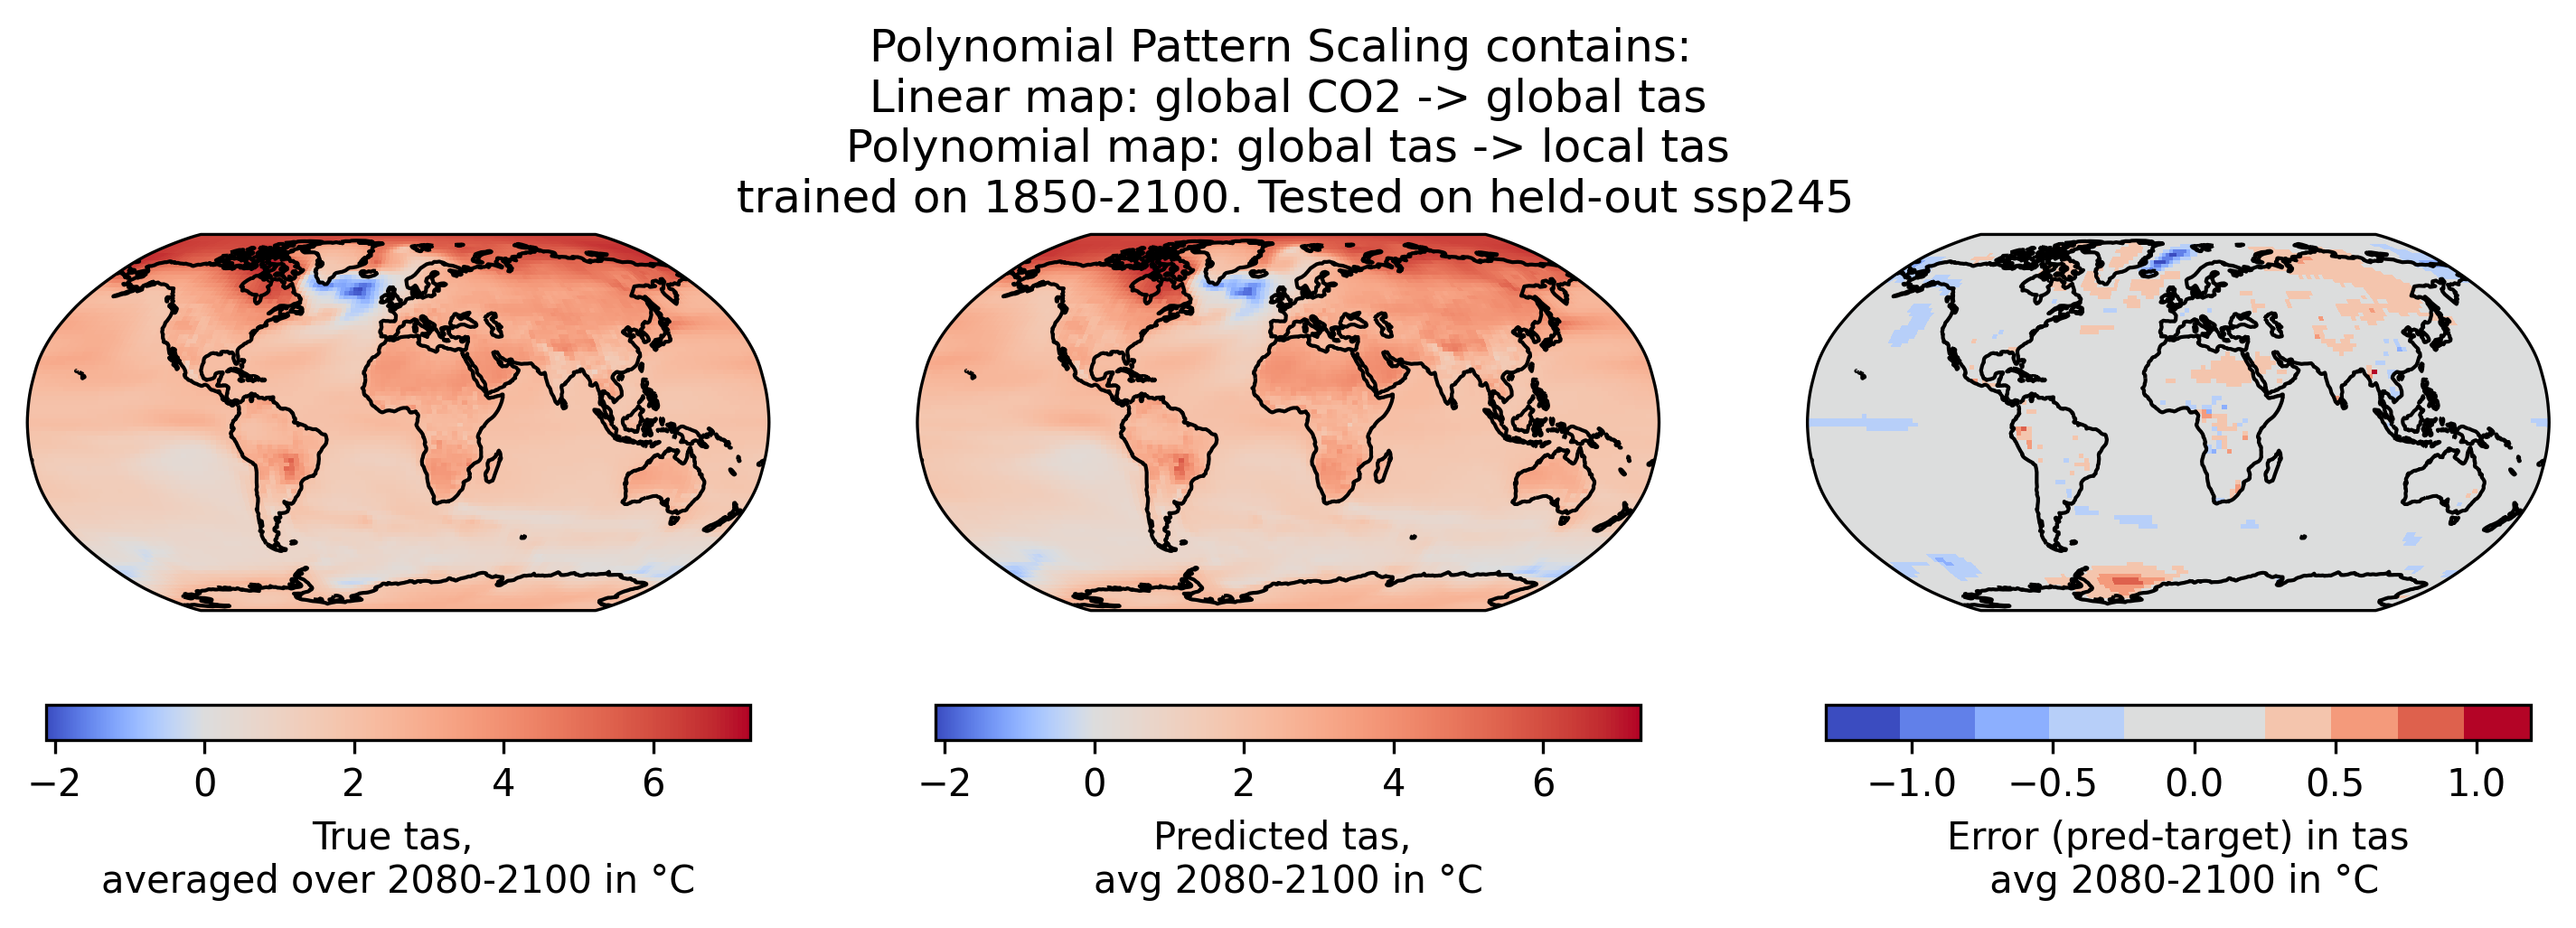

degree:	5:	 NRMSE:0.06827759054693626


In [19]:
# Train polynomial pattern scaling model.
    
degree = 5
pattern_scaling_poly = ps.PatternScaling(deg=degree)
pattern_scaling_poly.train(var_global, var_local)

# Apply pattern scaling model on test data
preds_pattern_scaling_poly = pattern_scaling_poly.predict(var_global_test) # (n_time, n_lat, n_lon)

# Convert into xarray
preds_pattern_scaling_poly_xr = xr.DataArray(data=preds_pattern_scaling_poly, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_poly_ds = [xr.merge([preds_pattern_scaling_poly_xr])]

# Plot error map
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], preds_pattern_scaling_poly_ds[0][data_var], data_var=data_var)
axs[1].set_title(f'Polynomial Pattern Scaling contains: \n Linear map: global CO2 -> global tas \n Polynomial map: global tas -> local {data_var} \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

# Calculate NRMSE
Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_poly_ds[0][data_var])
print(f'degree:\t{degree}:\t NRMSE:{Y_nrmse}')

# Conclusion<a name="conclusion"></a>

## Summary

To summarize, we have seen that one can emulate the relationship between co2 emissions and local temperature by using a linear model. Surprisingly, the linear model outperforms deep learning models on this task. This underlines the importance of starting simple: whenever we'd like to show that large ML models are good for something it's good to start with a linear model. Further, using ML needs a rigorous description of train/val/test splits to avoid overfitting on spurious correlations or internal variability. Lastly, there's 20PB in the CMIP6 data and it is significant effort to select the in-/output variables that are most interesting for research. Here, we conclude that ML research might be an overkill for emulating annually-averaged mean surface temperature anomalies and think that it might be better suited for emulating more complex variables, such as local aerosols or extreme value statistics. 

## Next Steps

This tutorial only gives a short insight into machine learning in climate science. There exist many outstanding challenges and we refer to some here:

- Modeling more complex variables:
  - Seasonal and daily statistics
  - Extreme statistics
  - Non-temperature dependent variables, such as aerosols
  - Variables with nonlinear relationship to cumulative co2 emissions, e.g., with hysteresis
  - Downstream climate impact variables, such as storm surge heights.
- Evaluate more metrics:
  - Plot temperature over time for each region of interest, e.g., New England, Beijing, etc.
  -	Evaluate extremes by calculating CRPS and match of probability density functions
- Incorporate more data from ESGF CMIP6 or custom model runs
- Computationally expensive simulations are ubiquitous in the environmental sciences. There's great value in extending emulator tool to different datasets, other that CMIP6. 

### todos:
- add video of tutorial presentation.

<a name="references"></a>
# References

Please cite this abstract if you consider this tutorial useful:
```
Lütjens, Björn, Lea M. Hadzic, Dava Newman, and Mark Veillette. "The Climate Pocket: Tutorial on Building Fast Emulators in Climate Modeling." AGU23 (2023). online: https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1304372
```

Other References

*   Cachay, R. et al. (2021). The World as a Graph: Improving El Niño Forecasts with Graph Neural Networks. https://doi.org/10.48550/arXiv.2104.05089.


*   Millar, R. et al. (2017). Emission budgets and pathways consistent with limiting warming to 1.5 °C. Nature Geoscience, 10, 741–747, https://doi.org/10.1038/ngeo3031.


*   O'Neill, B. C. et al. (2022). The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geosci. Model Dev., 9, 3461–3482, https://doi.org/10.5194/gmd-9-3461-2016.


*   Pathak et al. (2022). FourCastNet: A Global Data-Driven High-Resolution Weather Model Using Adaptive Fourier Neural Operators. https://doi.org/10.48550/arXiv.2202.11214.


*   Watson-Parris, D. et al. (2022). ClimateBench v1.0: A Benchmark for Data-Driven Climate Projections. Journal of Advances in Modeling Systems, 14(10), https://doi.org/10.1029/2021MS002954.

